<img src="../img/Logo.png" width="200">

# Aprendizaje por Imágenes
# Transferencia de aprendizaje (Modelos pre-entrenados)

### Profesor: Jorge Calvo

## Modelo Vgg16

Imagina que quieres enseñar a una computadora a reconocer diferentes objetos en imágenes, como perros, gatos, coches, etc. Para hacerlo, necesitarías miles y miles de imágenes etiquetadas, es decir, imágenes que ya tienen la información de qué objeto se muestra en cada una.

Entrenar un modelo de reconocimiento de objetos desde cero puede llevar mucho tiempo y recursos computacionales. Aquí es donde entra en juego un modelo preentrenado, como VGG16.

Un modelo preentrenado es un modelo de aprendizaje profundo que ya ha sido entrenado en un conjunto masivo de imágenes. En el caso de VGG16, ha sido entrenado en el conjunto de datos ImageNet (https://www.image-net.org/), que contiene millones de imágenes de diferentes categorías.

Durante el entrenamiento, VGG16 aprendió a reconocer características comunes en las imágenes, como bordes, formas y texturas, y a asociar esas características con las etiquetas de las imágenes. Esto significa que VGG16 ya ha aprendido una representación útil y general de las características visuales en las imágenes.

Cuando utilizas un modelo preentrenado como VGG16, puedes aprovechar ese conocimiento previo para resolver tareas específicas sin tener que entrenar desde cero. En lugar de entrenar todo el modelo, puedes tomar el modelo preentrenado y adaptarlo a tu problema específico.

### Estructura
<img src="../img/vgg.png" width="800">

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt





https://keras.io/api/applications/vgg/#vgg16-function

In [ ]:
# Cargar el modelo preentrenado VGG16
model = VGG16(weights='imagenet')

model.summary()

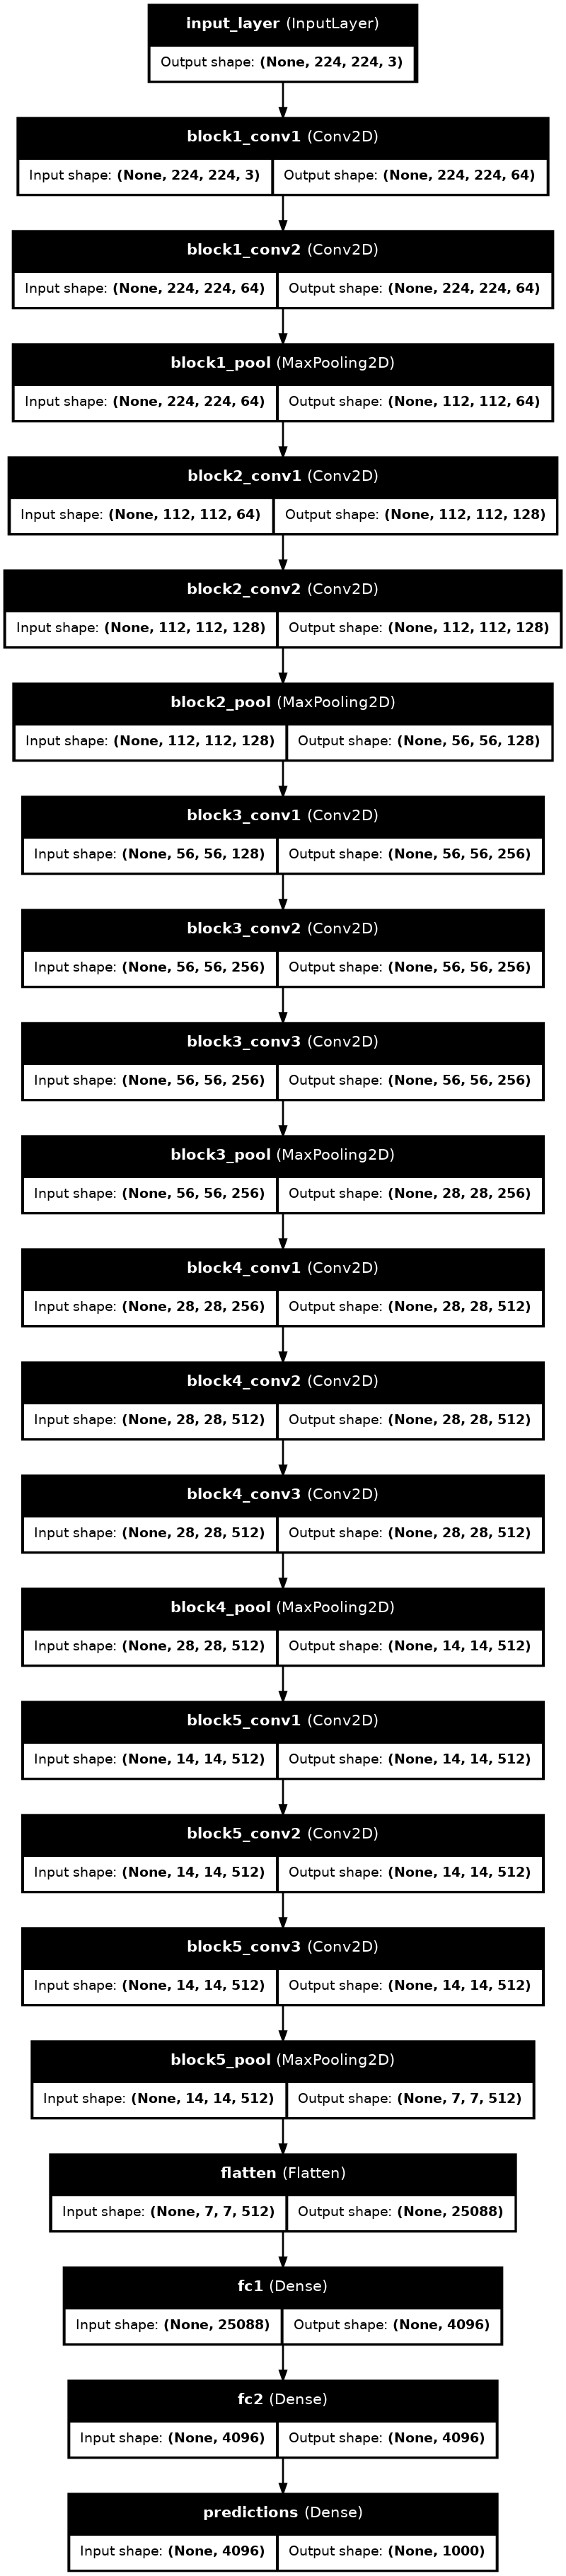

In [2]:
plot_model(model, to_file='./red_convolucional.png', show_shapes=True, show_layer_names=True, dpi=96)

In [3]:
# Cargar y preprocesar una imagen de ejemplo
img_path = '../images/camion.jpg'

#Le damos el tamaño admitido por Vgg16
img = image.load_img(img_path, target_size=(224, 224)) #Cargamos la imagen con el tamaño admitido por vgg16
x = image.img_to_array(img) #Convertimos la imagen en un array
x = np.expand_dims(x, axis=0) #Le añadimos la dimensión del batch
x = preprocess_input(x) #Le pasamos el procesamiento particular de vgg16

print("La imagen tiene la forma ",x.shape)

# Realizar la clasificación de la imagen
predictions = model.predict(x)
#Usamos la propiedad decoded_predictions para obetener la mejor probabilidad
decoded_predictions = decode_predictions(predictions, top=5)[0]

print(decoded_predictions)

La imagen tiene la forma  (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
[('n04467665', 'trailer_truck', 0.9914028), ('n03796401', 'moving_van', 0.0055362037), ('n04461696', 'tow_truck', 0.00088399847), ('n04252225', 'snowplow', 0.0006850955), ('n03417042', 'garbage_truck', 0.00039803536)]


In [4]:
# Imprimir las predicciones
for pred in decoded_predictions:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")

trailer_truck: 99.14%
moving_van: 0.55%
tow_truck: 0.09%
snowplow: 0.07%
garbage_truck: 0.04%


## Las activaciones de cada capa convolucional 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


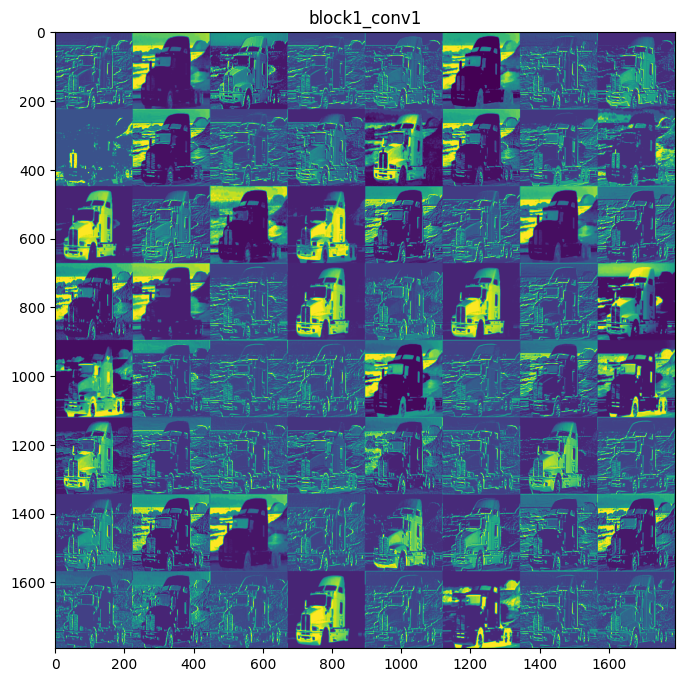

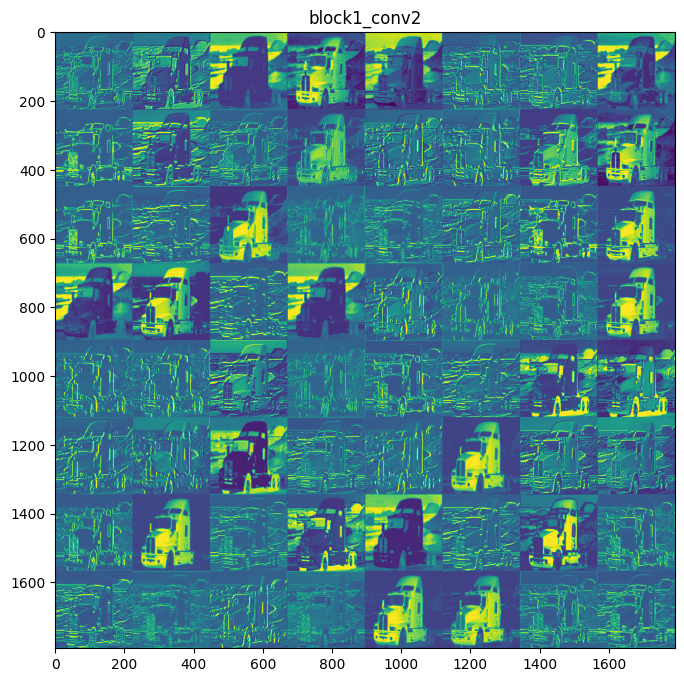

In [8]:
# Obtener las salidas de las diferentes capas por orden
#layer_outputs = [layer.output for layer in model.layers[1:19]]  # Capas convolucionales hasta block4_pool
#activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)


# Visualizar las salidas de las capas por nombres
selected_layers = ['block1_conv1', 'block1_conv2']
layer_outputs = [model.get_layer(layer_name).output for layer_name in selected_layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)


activations = activation_model.predict(x)

images_per_row = 8

for layer_name, layer_activation in zip(selected_layers, activations):
    num_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    # Crear una cuadrícula de imágenes para visualizar las activaciones
    rows = num_features // images_per_row
    display_grid = np.zeros((size * rows, images_per_row * size))

    for row in range(rows):
        for col in range(images_per_row):
            channel_image = layer_activation[0, :, :, row * images_per_row + col]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[row * size: (row + 1) * size, col * size: (col + 1) * size] = channel_image

    # Mostrar las activaciones de la capa
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()


## Fine-tuning Vgg16

In [10]:
# Init the VGG model
vgg_conv = VGG16(weights="imagenet", include_top=False, input_shape=(224,224, 3))

In [11]:
vgg_conv.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Para el proceso de Fine Tuning haremos entrenables las capas **block5_conv** que uniremos a nuestras capas finales de clasificación

In [12]:
vgg_conv.trainable=True
set_trainable=False

# Freeze all the layers
for layer in vgg_conv.layers[:]:
  if layer.name == "block5_conv1":
     set_trainable=True 
  if set_trainable:
     layer.trainable=True
  else: layer.trainable=False   
 
# Check the trainable status of the individual layers

for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer_2, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<MaxPooling2D name=block5_pool, built=True> True


In [18]:
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [19]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 19,930,122 (76.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

None
